# Sociation2vec
## Поиск лишнего слова и кластеризация синонимов

In [1]:
import os
from operator import itemgetter
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as progress
import gensim

In [2]:
source_dir = "./source_corpus"
model_dir = "/Users/ur001/Documents/Sociation/sociation2vec_model"
random_state = 777

%pylab inline
%config InlineBackend.figure_format = 'svg' 
%config InlineBackend.figure_format = 'retina'

# отключаем ворнинги
import warnings
warnings.simplefilter('ignore')

# дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 14,9

Populating the interactive namespace from numpy and matplotlib


## Загрузка словарей и корпуса ассоциаций

In [3]:
%load_ext autoreload
%autoreload 2
from sociation2vec.utils import DictEncoder, save_word2vec, read_word2vec
from sociation2vec.model import Sociation2Vec
from sociation2vec import mathutils, model_builder, pandas_utils

In [4]:
corpus, words_dict, assoc_dict = model_builder.load_source_corpus(source_dir)
words_count = len(words_dict.decode)
assoc_count = len(assoc_dict.decode)
print("Слов: {}, Слов-ассоциаций: {}".format(words_count, assoc_count))

Loading source corpus...
Loading words index...
Loading assoc words index...
Words: 27930, Assoc words: 46145
Слов: 27930, Слов-ассоциаций: 46145


In [5]:
sociation2vec_builder = model_builder.ModelBuilder(source_path=source_dir, out_path=model_dir)
sociation2vec = sociation2vec_builder.get_model(
    ppmi_k=5.5, 
    svd_components=790, 
    tfidf_smooth_tf=False
)

Loading source corpus...
Loading words index...
Loading assoc words index...
Words: 27930, Assoc words: 46145
Normalizing source sorpus...
Applying PPMI cds=0.75, neg=5.5...
Applying TFIDF smooth_tf=False...
Loading corpus from /Users/ur001/Documents/Sociation/sociation2vec_model/corpus_norm_ppmi_0.75_5.5_tfidf_svd_norm_790.npy...
Loading model from /Users/ur001/Documents/Sociation/sociation2vec_model/model_norm_ppmi_0.75_5.5_tfidf_svd_norm_790.pkl...
Loading similarity index from /Users/ur001/Documents/Sociation/sociation2vec_model/norm_ppmi_0.75_5.5_tfidf_svd_norm_790.index


In [6]:
get_similar = pandas_utils.build_get_similar(sociation2vec)
compare = pandas_utils.build_compare(sociation2vec)
doesnt_match = pandas_utils.build_doesnt_match(sociation2vec)

In [7]:
get_similar('король,-мужчина,женщина')

,similarity
word,
королева,0.554321
корона,0.495448
царица,0.464954
королевство,0.461848
монархия,0.440829
трон,0.435679
коронация,0.433126
монарх,0.431571
царство,0.427857


In [8]:
sociation2vec.get_similarity_matrix('кошка,собака,окно'.split(','))

array([[1.        , 0.3890086 , 0.07921923],
       [0.3890086 , 1.        , 0.03341346],
       [0.07921923, 0.03341346, 1.        ]])

In [9]:
sociation2vec.get_not_match_word('кошка,собака,окно'.split(','))

'окно'

In [10]:
doesnt_match('кошка,собака,окно')

окно


In [11]:
doesnt_match('москва,лондон,тула,новосибирск')

лондон


In [12]:
doesnt_match('кошка,собака,птица')

птица


In [13]:
doesnt_match('лебедь,рак,щука')

лебедь


In [14]:
doesnt_match('джаз,гранж,блюз,фанк')

гранж


In [15]:
doesnt_match('роберт шекли,достоевский,рэй брэдбери,пелевин')

достоевский


In [16]:
doesnt_match('маша,катя,ваня,оля')

ваня


In [17]:
doesnt_match('квадрат,ромб,прямоугольник,круг')

круг


In [18]:
doesnt_match('ложка,тарелка,нож,вилка')  # ???

нож


In [19]:
doesnt_match('цветок,дерево,заяц')

цветок


In [20]:
doesnt_match('берёза,осина,земляника')

земляника


In [21]:
doesnt_match('стул,табуретка,ящик')

ящик


In [22]:
doesnt_match('россия,америка,париж')

париж


In [23]:
doesnt_match('торт,сыр,пастила,мармелад')

сыр


In [24]:
doesnt_match('пенал,портфель,ранец')

пенал


In [25]:
doesnt_match('шашлык,салат,стейк,отбивная')

салат


In [26]:
doesnt_match('человек,лиза,паша')

человек


In [27]:
doesnt_match('колокол,будильник,лампа')

лампа


In [28]:
doesnt_match('маньяк,террорист,убийца,продавец')

продавец


In [29]:
doesnt_match('медведь,заяц,таракан')

таракан


In [30]:
doesnt_match('мурзик,барсик,шарик')

шарик


In [31]:
doesnt_match('пушкин,лермонтов,достоевский')

достоевский


## Клстеризация графа, разделение по смыслу

In [32]:
def get_similarity_matrix_from_mos_similar(word_names, count=50):
    word_names = word_names.lower().split(',')
    most_similar = sociation2vec.get_top_similar_to_words(word_names, count=count)
    most_similar_words, words_similarity = zip(*most_similar)
    return (
        most_similar_words, 
        np.array(words_similarity),
        sociation2vec.get_similarity_matrix(most_similar_words),
    )

In [33]:
word_names, word_similarity, pairwise_distances = get_similarity_matrix_from_mos_similar('система')

In [34]:
from sklearn.cluster import AffinityPropagation, SpectralClustering

In [35]:
af = AffinityPropagation(affinity='precomputed', damping=0.94, preference=word_similarity)
af.fit(pairwise_distances)

AffinityPropagation(affinity='precomputed', convergence_iter=15, copy=True,
          damping=0.94, max_iter=200,
          preference=array([0.53748, 0.50608, 0.48712, 0.45493, 0.45182, 0.44317, 0.43664,
       0.43446, 0.43017, 0.42718, 0.42679, 0.42572, 0.42504, 0.42007,
       0.41856, 0.40121, 0.40104, 0.38931, 0.38523, 0.38258, 0.37563,
       0.37489, 0.3724 , 0.36953, 0.36827, 0.36753, 0.36135, 0.36107,
       0....      0.33758, 0.33678, 0.33037, 0.32888, 0.32742, 0.32703, 0.32649,
       0.32631], dtype=float32),
          verbose=False)

In [36]:
af.cluster_centers_indices_

array([ 4,  7,  8, 10, 11, 15, 16, 21, 24, 26, 31, 32])

In [37]:
for clust_n, clust_word_idx in enumerate(af.cluster_centers_indices_):
    print("{}\n---------------".format(word_names[clust_word_idx]))
    for word_idx, word_clust_n in enumerate(af.labels_):
        if word_clust_n == clust_n:
            print(word_names[word_idx])
    print("")

настройки
---------------
настройки
саморегуляция
установка
варез
опции

компьютер
---------------
компьютер
прошивка
биос
файл

программирование
---------------
алгоритм
программа
программирование
программы
программист

убунту
---------------
операционная система
виндоус
юникс
линукс
убунту
майкрософт
перезагрузка
ос
многозадачность
интернет эксплорер
эксель
мак ос

упорядоченность
---------------
структура
упорядоченность
системы
порядок

двоичный код
---------------
двоичный код
данные
бинарная номенклатура
скрипт
матрица
компиляция
кодировка

систематизация
---------------
систематизация
сортировка

вложенность
---------------
вложенность

параметры
---------------
параметры
параметр
математика

солнечная система
---------------
солнечная система
гелиоцентризм
птолемей

целостность
---------------
целостность
совокупность
цельность

схема
---------------
схема



In [38]:
def print_word_clustering(word_names, count=50, damping=0.95):
    words, similarity, distances = get_similarity_matrix_from_mos_similar(word_names, count=count)
    af = AffinityPropagation(affinity='precomputed', damping=damping)
    af.fit(distances)
    
    for clust_n, clust_word_idx in enumerate(af.cluster_centers_indices_):
        print("{}\n---------------".format(words[clust_word_idx]))
        for word_idx, word_clust_n in enumerate(af.labels_):
            if word_clust_n == clust_n:
                print(words[word_idx])
        print("")

In [39]:
print_word_clustering('система', damping=0.95)

настройки
---------------
настройки
саморегуляция
установка
параметры
варез
параметр
опции

программирование
---------------
алгоритм
программа
компьютер
программирование
программы
программист
математика

убунту
---------------
операционная система
виндоус
юникс
линукс
убунту
прошивка
майкрософт
перезагрузка
ос
биос
многозадачность
интернет эксплорер
эксель
мак ос
файл

упорядоченность
---------------
структура
упорядоченность
систематизация
вложенность
системы
порядок
сортировка

двоичный код
---------------
двоичный код
данные
бинарная номенклатура
скрипт
матрица
компиляция
кодировка

целостность
---------------
целостность
совокупность
цельность

гелиоцентризм
---------------
солнечная система
схема
гелиоцентризм
птолемей



In [40]:
print_word_clustering('ключ')

брелок
---------------
брелок
ключик
ключи
замочек
ключница
замочная скважина
ключник
золотой ключик
автомеханик
идентификатор

отмычки
---------------
отмычка
отмычки
сейф
взлом
медвежатник

шифр
---------------
шифр
первичный ключ
пароль
секрет
код
криптография
шифровка
тайник

дверь
---------------
замок
дверь
засов
щеколда
защёлка
открывание
двери
домофон
дверца
дверка
замки

родник
---------------
скважина
родник
родничок
источник

гайка
---------------
гаечный ключ
отвёртка
гайка
болтик
отверстие
шестигранник

отгадка
---------------
отгадка
разгадка

нотный стан
---------------
басовый ключ
бемоль
скрипичный ключ
нотный стан



In [41]:
def print_word_clustering2(word_names, count=50, n_clusters=5):
    words, similarity, distances = get_similarity_matrix_from_mos_similar(word_names, count=count)
    cl = SpectralClustering(affinity='precomputed', n_clusters=n_clusters)
    cl.fit(distances)
    
    for clust_n in range(n_clusters):
        print("{}\n---------------".format(clust_n + 1))
        for word_idx, word_clust_n in enumerate(cl.labels_):
            if word_clust_n == clust_n:
                print(words[word_idx])
        print("")

In [42]:
print_word_clustering2('система', n_clusters=5)

1
---------------
целостность
совокупность
цельность

2
---------------
алгоритм
программа
настройки
компьютер
программирование
двоичный код
данные
установка
программы
вложенность
параметры
бинарная номенклатура
скрипт
варез
параметр
схема
матрица
программист
компиляция
кодировка
эксель
математика
файл
опции

3
---------------
структура
упорядоченность
систематизация
системы
порядок
сортировка

4
---------------
солнечная система
гелиоцентризм
птолемей

5
---------------
операционная система
виндоус
юникс
линукс
убунту
прошивка
саморегуляция
майкрософт
перезагрузка
ос
биос
многозадачность
интернет эксплорер
мак ос



In [43]:
print_word_clustering2('ключ', n_clusters=8)

1
---------------
отмычка
отмычки
взлом
медвежатник

2
---------------
гаечный ключ
отвёртка
гайка
болтик
шестигранник

3
---------------
брелок
ключик
ключи
ключница
ключник
скважина
родник
золотой ключик
автомеханик
родничок
источник

4
---------------
замок
замочная скважина
дверь
засов
щеколда
защёлка
открывание
двери
домофон
дверца
дверка
замки

5
---------------
замочек
сейф
секрет
тайник
отверстие

6
---------------
шифр
первичный ключ
пароль
код
криптография
шифровка
идентификатор

7
---------------
басовый ключ
бемоль
скрипичный ключ
нотный стан

8
---------------
отгадка
разгадка



In [44]:
print_word_clustering('Ствол')

пистолет
---------------
обойма
пистолет
калибр
цевьё
патроны
ружьё
патрон
дуло
пуля
приклад
винтовка
курок
выстрел
двустволка
пулемёт
обрез
оружие
пыж
дробовик
стрельба
пушка
двухстволка
пули
наган
револьвер
прицел
порох
ружья
маузер
магнум
автомат
гильза
волына
затвор
шомпол
снайперка
пулька
мушка
зенитка

ветви
---------------
дерево
ветка
дуб
ветви
крона
раскидистость
кора
стволы
ветки
ветвь
берёза



In [45]:
print_word_clustering('Замок', 20)

щеколда
---------------
засов
замки
щеколда
защёлка
шпингалет

ключ
---------------
замочек
ключ
ключик
ключница
ключи
брелок

дверь
---------------
дверь
замочная скважина
двери

отмычки
---------------
отмычка
отмычки
сейф

бастион
---------------
крепость
бастион
цитадель



In [46]:
print_word_clustering2('Замок', 20, n_clusters=2)

1
---------------
засов
щеколда
защёлка
замочек
ключ
отмычка
дверь
отмычки
замочная скважина
шпингалет
ключик
ключница
ключи
брелок
сейф
двери

2
---------------
замки
крепость
бастион
цитадель



In [47]:
print_word_clustering('Пост', 50)

караул
---------------
караул
дневальный
часовой
караульный
дозор
дежурный

вахта
---------------
вахта
дежурство
кпп
вахтёр
консьержка
смена

твит
---------------
твит
блог
микроблоггинг
живой журнал
соцсети
пикабу
комменты

гаи
---------------
патруль
гаи
гибдд
дпс
жезл
инспектор
гаишник
взятка
инспекция

милиционер
---------------
постовой
городовой
милиционер
мент
регулировщик
служба
милиция
менты
дядя стёпа
дубинка
полиция
днд
страж порядка

охрана
---------------
охранник
охрана
сторож
страж
секьюрити
ведомство

великий пост
---------------
великий пост
голодовка
седмица



In [48]:
print_word_clustering('Горшок', 20)

какашки
---------------
герань
детская неожиданность
какашки
какашка
подгузник
подгузники
фекалии

обжиг
---------------
кашпо
вазон
фондюшница
цветовод
фикус
гончар
обжиг
ваза
глина
орхидея
кадка
чугунок
керамика



In [49]:
print_word_clustering2('Горшок', 17, 2)

1
---------------
кашпо
вазон
герань
фондюшница
цветовод
фикус
гончар
обжиг
ваза
глина
орхидея
кадка

2
---------------
детская неожиданность
какашки
какашка
подгузник
подгузники



In [50]:
print_word_clustering('Коса', 10)

косы
---------------
косы
волосы
русый цвет
косичка

покос
---------------
покос
косарь
сенокос
сноп
косилка
скирда



In [53]:
print_word_clustering('Камера')

съёмка
---------------
съёмка
видеокамера
крупный план
видео
кинокамера
монтаж
камеры
съёмки
камера-обскура
камерон
киноплёнка

фотоаппарат
---------------
фотоаппарат
снимки
кодак
объектив
штатив
фотограф
кадр
зеркалка
никон
фото
поляроид
трансфокация
макросъёмка
фотография
снимок
плёнка
ракурс
инстаграм
объективы
фотопленка
фотоэлемент

кпз
---------------
кпз
наплыв
отсидка
сизо
обскура
казематы
шконка

заключённый
---------------
тюряга
заключённый
тюрьма
арестант
нары
надзиратель
узник
заточение

видеоблогер
---------------
кодек
авторегистратор
видеоблогер



In [54]:
print_word_clustering2('Камера', 50, 3)

1
---------------
фотоаппарат
снимки
кодак
объектив
штатив
фотограф
кадр
зеркалка
никон
фото
поляроид
трансфокация
макросъёмка
фотография
снимок
плёнка
ракурс
инстаграм
объективы
фотопленка
фотоэлемент

2
---------------
съёмка
видеокамера
крупный план
наплыв
видео
кодек
кинокамера
монтаж
камеры
обскура
съёмки
камера-обскура
камерон
киноплёнка
авторегистратор
видеоблогер

3
---------------
кпз
отсидка
сизо
тюряга
казематы
заключённый
тюрьма
арестант
нары
шконка
надзиратель
узник
заточение



In [55]:
print_word_clustering2('Кисть', 50, 2)

1
---------------
рука
запястье
фаланга
предплечье
пятерня

2
---------------
мольберт
кисти
холст
кисточка
акварель
краски
гуашь
мазня
мазок
палитра
кисточки
краска
художество
живопись
мазки
художник
рисование
живописец
темпера
этюдник
мастихин
рисунок
этюд
маляр
картина
белила
полотно
пленэр
акрил
натюрморт
пастель
подрамник
портрет
маринист
ван гог
грунтовка
рисунки
окрас
пейзаж
покраска
скетчбук
валик
колорирование
картины
айвазовский



In [56]:
print_word_clustering2('Клетка', 50, 2)

1
---------------
зверинец
решётка
зоопарк
сокамерник
морской бой
клеточка
заточение
неволя
сизо
вольер
обезьянник
узник
шотландка
зоосад
зверята
кролики
решётки
дегу
линейки
крестики-нолики

2
---------------
клетки
органелла
митохондрия
вакуоль
рибосома
биология
простейшие
митоз
инфузория-туфелька
амёба
микробиология
мейоз
инфузория
хлоропласт
хромосома
рнк
одноклеточное
днк
хромосомы
нуклеотид
размножение
зигота
мембрана
организм
бактерия
эритроциты
микромир
живой организм
молекула
микроскоп



In [57]:
print_word_clustering2('Орган', 20, 2)

1
---------------
клавир
органный зал
хаммонд
фортепиано
клавишные
клавесин
электроорган
пианино
рояль
реквием

2
---------------
селезёнка
органы
аппендикс
печёнка
печень
внутренность
анатомия
кишки
член
внутренности



In [58]:
print_word_clustering2('Паста', 30, 2)

1
---------------
спагетти
песто
болоньезе
лазанья
макароны
макаронник
соус
томаты
кетчуп
бешамель
моцарелла
пармезан
пицца
италия
лапша
капрезе
равиоли
вермишель
томат
мастрояни
томатный соус
подлива
итальянцы

2
---------------
колгейт
зубной порошок
зубная паста
блендамед
еда космонавтов
зубная щётка
щётка



In [59]:
print_word_clustering('сон')

сонливость
---------------
дрёма
дремота
сонливость
бессоница
пробуждение
недосып
бессонница
усталость
зевота
снотворное

быстрая фаза
---------------
полусон
сон разума
быстрая фаза
бодрствование
храп
лунатизм
осознанное сновидение
морфей
ночь
бессознательное
кошмар
свёртка
сомнамбула
кошмары
коматоз

кровать
---------------
подушка
кровать
постелька
постель
лежание
одеяло
нега
спальня
пододеяльник
перина
отдых
матрас

грёзы
---------------
сновидение
сны
сновидения
грёзы
греза
видения
явь
мечты
фантазии
образы
иллюзии
фантазия
воображение



In [51]:
from collections import defaultdict

def take_item_or_blank(max_count):
    def iterator(items, blank=''):
        count = 0
        for item in items:
            count += 1
            yield item
            
        while count < max_count:
            count += 1
            yield blank
        
    return iterator

        
def similar_clust(word_names, count=50, n_clusters=None, damping=0.95):
    words, similarity, distances = get_similarity_matrix_from_mos_similar(word_names, count=count)
    
    if n_clusters:
        cl = SpectralClustering(affinity='precomputed', n_clusters=n_clusters)
    else:    
        cl = AffinityPropagation(affinity='precomputed', damping=damping)

    cl.fit(distances)
    
    if n_clusters:
        cluster_names = list(map(str, range(n_clusters)))
    else:
        n_clusters = len(cl.cluster_centers_indices_)
        cluster_names = [words[idx] for idx in cl.cluster_centers_indices_]
        
    clusters = [[] for _ in range(n_clusters)]
        
    for word_idx, word_clust_n in enumerate(cl.labels_):
        clusters[word_clust_n].append(words[word_idx])
    
    clusters_words_iterator = take_item_or_blank(max(map(len, clusters)))    
    return pd.DataFrame([
        row_words
        for row_words
        in zip(*map(clusters_words_iterator, clusters))
    ], columns=cluster_names)
              

In [52]:
similar_clust('сон', 50, 5)

,0,1,2,3,4
0,сны,полусон,подушка,дрёма,сновидение
1,сновидения,сон разума,кровать,дремота,бодрствование
2,грёзы,быстрая фаза,засыпание,сонливость,бессоница
3,греза,сончас,постель,пробуждение,храп
4,явь,лунатизм,постелька,недосып,кошмары
5,видения,морфей,одеяло,нега,ночь
6,мечты,бессознательное,лежание,усталость,кошмар
7,фантазии,осознанное сновидение,пододеяльник,зевота,бессонница
8,иллюзии,свёртка,спальня,отдых,
9,образы,сомнамбула,перина,,


In [53]:
similar_clust('сон')

,сонливость,быстрая фаза,кровать,грёзы
0,дрёма,сновидение,подушка,сны
1,дремота,полусон,кровать,сновидения
2,сонливость,сон разума,засыпание,грёзы
3,бессоница,быстрая фаза,постель,греза
4,пробуждение,бодрствование,постелька,явь
5,недосып,сончас,одеяло,видения
6,бессонница,храп,лежание,мечты
7,усталость,лунатизм,нега,фантазии
8,зевота,морфей,ночь,иллюзии
9,,кошмары,пододеяльник,образы


In [54]:
similar_clust('система')

,настройки,программирование,убунту,упорядоченность,двоичный код,целостность,гелиоцентризм
0,настройки,алгоритм,операционная система,структура,двоичный код,целостность,солнечная система
1,саморегуляция,программа,виндоус,упорядоченность,данные,совокупность,схема
2,установка,компьютер,юникс,систематизация,бинарная номенклатура,цельность,гелиоцентризм
3,параметры,программирование,линукс,вложенность,скрипт,,птолемей
4,варез,программы,убунту,системы,матрица,,
5,параметр,программист,прошивка,порядок,компиляция,,
6,опции,математика,майкрософт,сортировка,кодировка,,
7,,,перезагрузка,,,,
8,,,ос,,,,
9,,,биос,,,,


In [55]:
similar_clust('любовь')

,взаимность,чувства,доверие,объятия,муж,удовольствие
0,взаимность,чувства,доверие,близость,ревность,счастье
1,отношения,влюблённость,преданность,нежность,семейная жизнь,секс
2,привязанность,чувство,дружба,объятия,муж,удовольствие
3,симпатия,страсть,искренность,поцелуй,супруги,радость
4,любимый человек,чувственность,верность,объятие,семья,приятность
5,эмпатия,трепет,забота,обнимашки,измена,
6,отношение,влечение,взаимопонимание,теплота,жена,
7,,эмоции,,поцелуи,возлюбленный,
8,,нежности,,романтика,любимый,
9,,ощущение,,ласка,,


In [56]:
similar_clust('срамота')

,порнофильм,порно,мастурбация,вульгарность,старухи,нагота,извращение,гениталии
0,порнофильм,фистинг,фаллоимитатор,вульгарность,старухи,непристойность,вуайеризм,писька
1,тинто брасс,порнография,мастурбация,быдлокультура,классный руководитель,голое тело,копрофилия,пенис
2,пошлятина,порно,онанизм,,прабабушка,голая женщина,извращение,гениталии
3,оханье,анальный секс,куннилингус,,,ню,девиация,
4,групповуха,мокрые трусики,стоны,,,обнажённость,,
5,двойное проникновение,писсинг,,,,нагота,,
6,роскомнадзор,эротика,,,,стыдоба,,
7,дукат,хентай,,,,эксгибиционизм,,
8,дрочка,видеоарт,,,,,,
9,дилдо,ебля,,,,,,


In [57]:
similar_clust('секс', damping=0.5)

,половой акт,удовольствие,похоть,куннилингус,порно,сперма,близость
0,половой акт,оргазм,похоть,куннилингус,порно,эякуляция,интим
1,совокупление,удовольствие,страсть,мастурбация,эротика,влагалище,любовь
2,ебля,возбуждение,вожделение,оральный секс,онанизм,сперма,близость
3,коитус,наслаждение,влечение,ласки,анал,зачатие,
4,эрекция,удовлетворение,либидо,минет,,презерватив,
5,соитие,экстаз,разврат,клитор,,,
6,сношение,приятность,прелюбодеяние,фелляция,,,
7,сквирт,,желание,прелюдия,,,
8,член,,оргия,стоны,,,
9,трах,,,стимуляция,,,


In [58]:
similar_clust('ключ', 50)

,брелок,отмычки,шифр,дверь,родник,гайка,отгадка,нотный стан
0,брелок,отмычка,шифр,замок,скважина,гаечный ключ,отгадка,басовый ключ
1,ключик,отмычки,первичный ключ,дверь,родник,отвёртка,разгадка,бемоль
2,ключи,сейф,пароль,засов,родничок,гайка,,скрипичный ключ
3,замочек,взлом,секрет,щеколда,источник,болтик,,нотный стан
4,ключница,медвежатник,код,защёлка,,отверстие,,
5,замочная скважина,,криптография,открывание,,шестигранник,,
6,ключник,,шифровка,двери,,,,
7,золотой ключик,,тайник,домофон,,,,
8,автомеханик,,,дверца,,,,
9,идентификатор,,,дверка,,,,


In [59]:
similar_clust('гид')

,путешествие,музей
0,экскурсия,экскурсовод
1,турне,достопримечательность
2,путеводитель,музей
3,туризм,западник
4,достопримечательности,экспозиция
5,тур,лувр
6,кругосветное путешествие,предыстория
7,путешествие,эрмитаж
8,бэкпэкер,ротозей
9,вояж,экспонат


In [60]:
similar_clust('коса', 10)

,косы,покос
0,косы,покос
1,волосы,косарь
2,русый цвет,сенокос
3,косичка,сноп
4,,косилка
5,,скирда


In [79]:
word_names, word_similarity, pairwise_distances = get_similarity_matrix_from_mos_similar('система', 50)

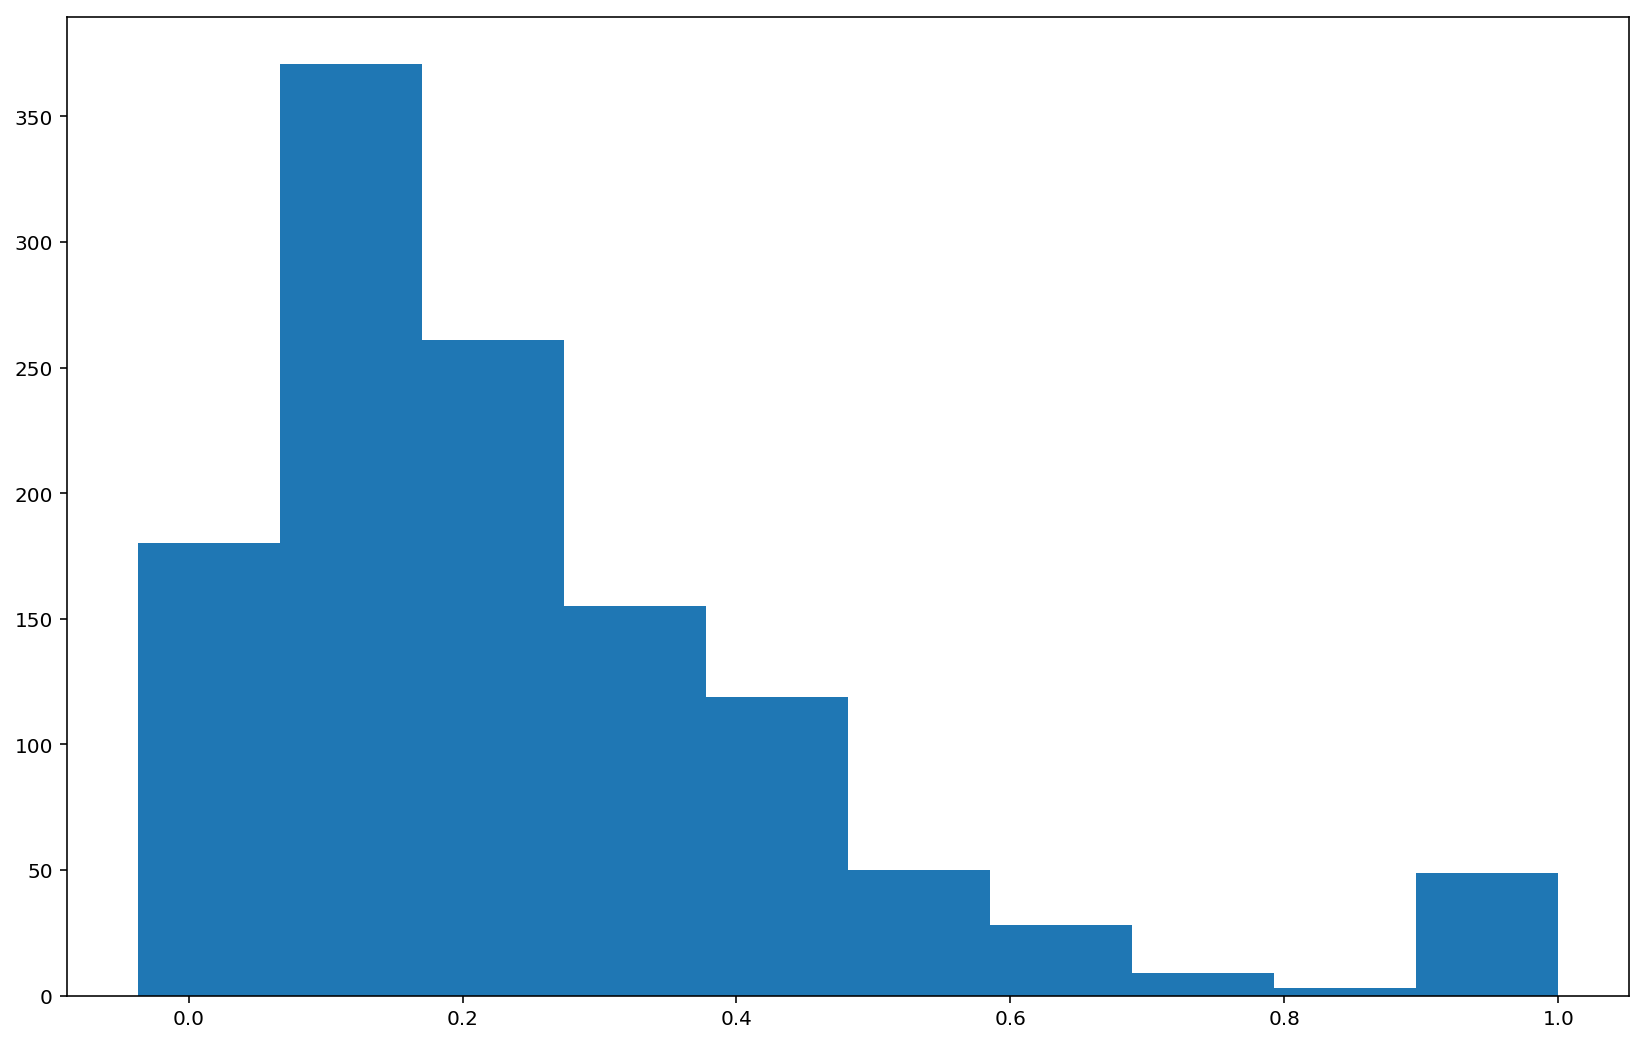

In [80]:
def get_diagonal(matr):
    size = matr.shape[0]
    return np.array([
        matr[x, y]
        for x in range(1, size)
        for y in range(x, size)
    ])
            
plt.hist(get_diagonal(pairwise_distances));

In [81]:
from sklearn.decomposition import PCA, TruncatedSVD

def plot_similar(word_names, count=50, method='pca', distance3d=True):
    # Топ похожих слов
    word_names = word_names.lower().split(',')
    most_similar = sociation2vec.get_top_similar_to_words(word_names, count=count)
    
    # Матрица векторов всех похожих слов
    most_similar_words, words_similarity = zip(*most_similar)
    similar_words_matrix = sociation2vec.get_words_matrix(most_similar_words)
    
    # Попарная близость похожих слов между собой
    if not distance3d:
        similar_words_distances = similar_words_matrix.dot(similar_words_matrix.T)
    
    else:
        # сначала снижаем размерность до 3D
        svd = TruncatedSVD(n_components=3, random_state=random_state)
        similar_words_matrix_3d = svd.fit_transform(similar_words_matrix)
        similar_words_distances = similar_words_matrix_3d.dot(similar_words_matrix_3d.T)
    
    # Кластеризация похохожих слов на основе вычесленной матрицы попарной близости
    clust = AffinityPropagation(affinity='precomputed', damping=0.95)
    clust.fit(similar_words_distances)    
    
    # Уменьшение размерности пространства до 2 с пмощью PCA/SVD
    if method == 'pca':
        scale2d = PCA(n_components=2, copy=False, random_state=random_state)
    elif method == 'svd':
        scale2d = TruncatedSVD(n_components=2, random_state=random_state)
    else:
        raise Exception('Wrong method {}'.format(method))
        
    similar_words_2d = scale2d.fit_transform(similar_words_matrix)    
    x, y = similar_words_2d[:, 0], similar_words_2d[:, 1]
    
#     clust.fit(similar_words_2d.dot(similar_words_2d.T)) 
    
    # График
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.scatter(x, y, np.array(words_similarity) * 200, clust.labels_, alpha=0.8)
    for word, x, y in zip(most_similar_words, x, y):
        ax.annotate(word, (x - 0.03, y + 0.012))

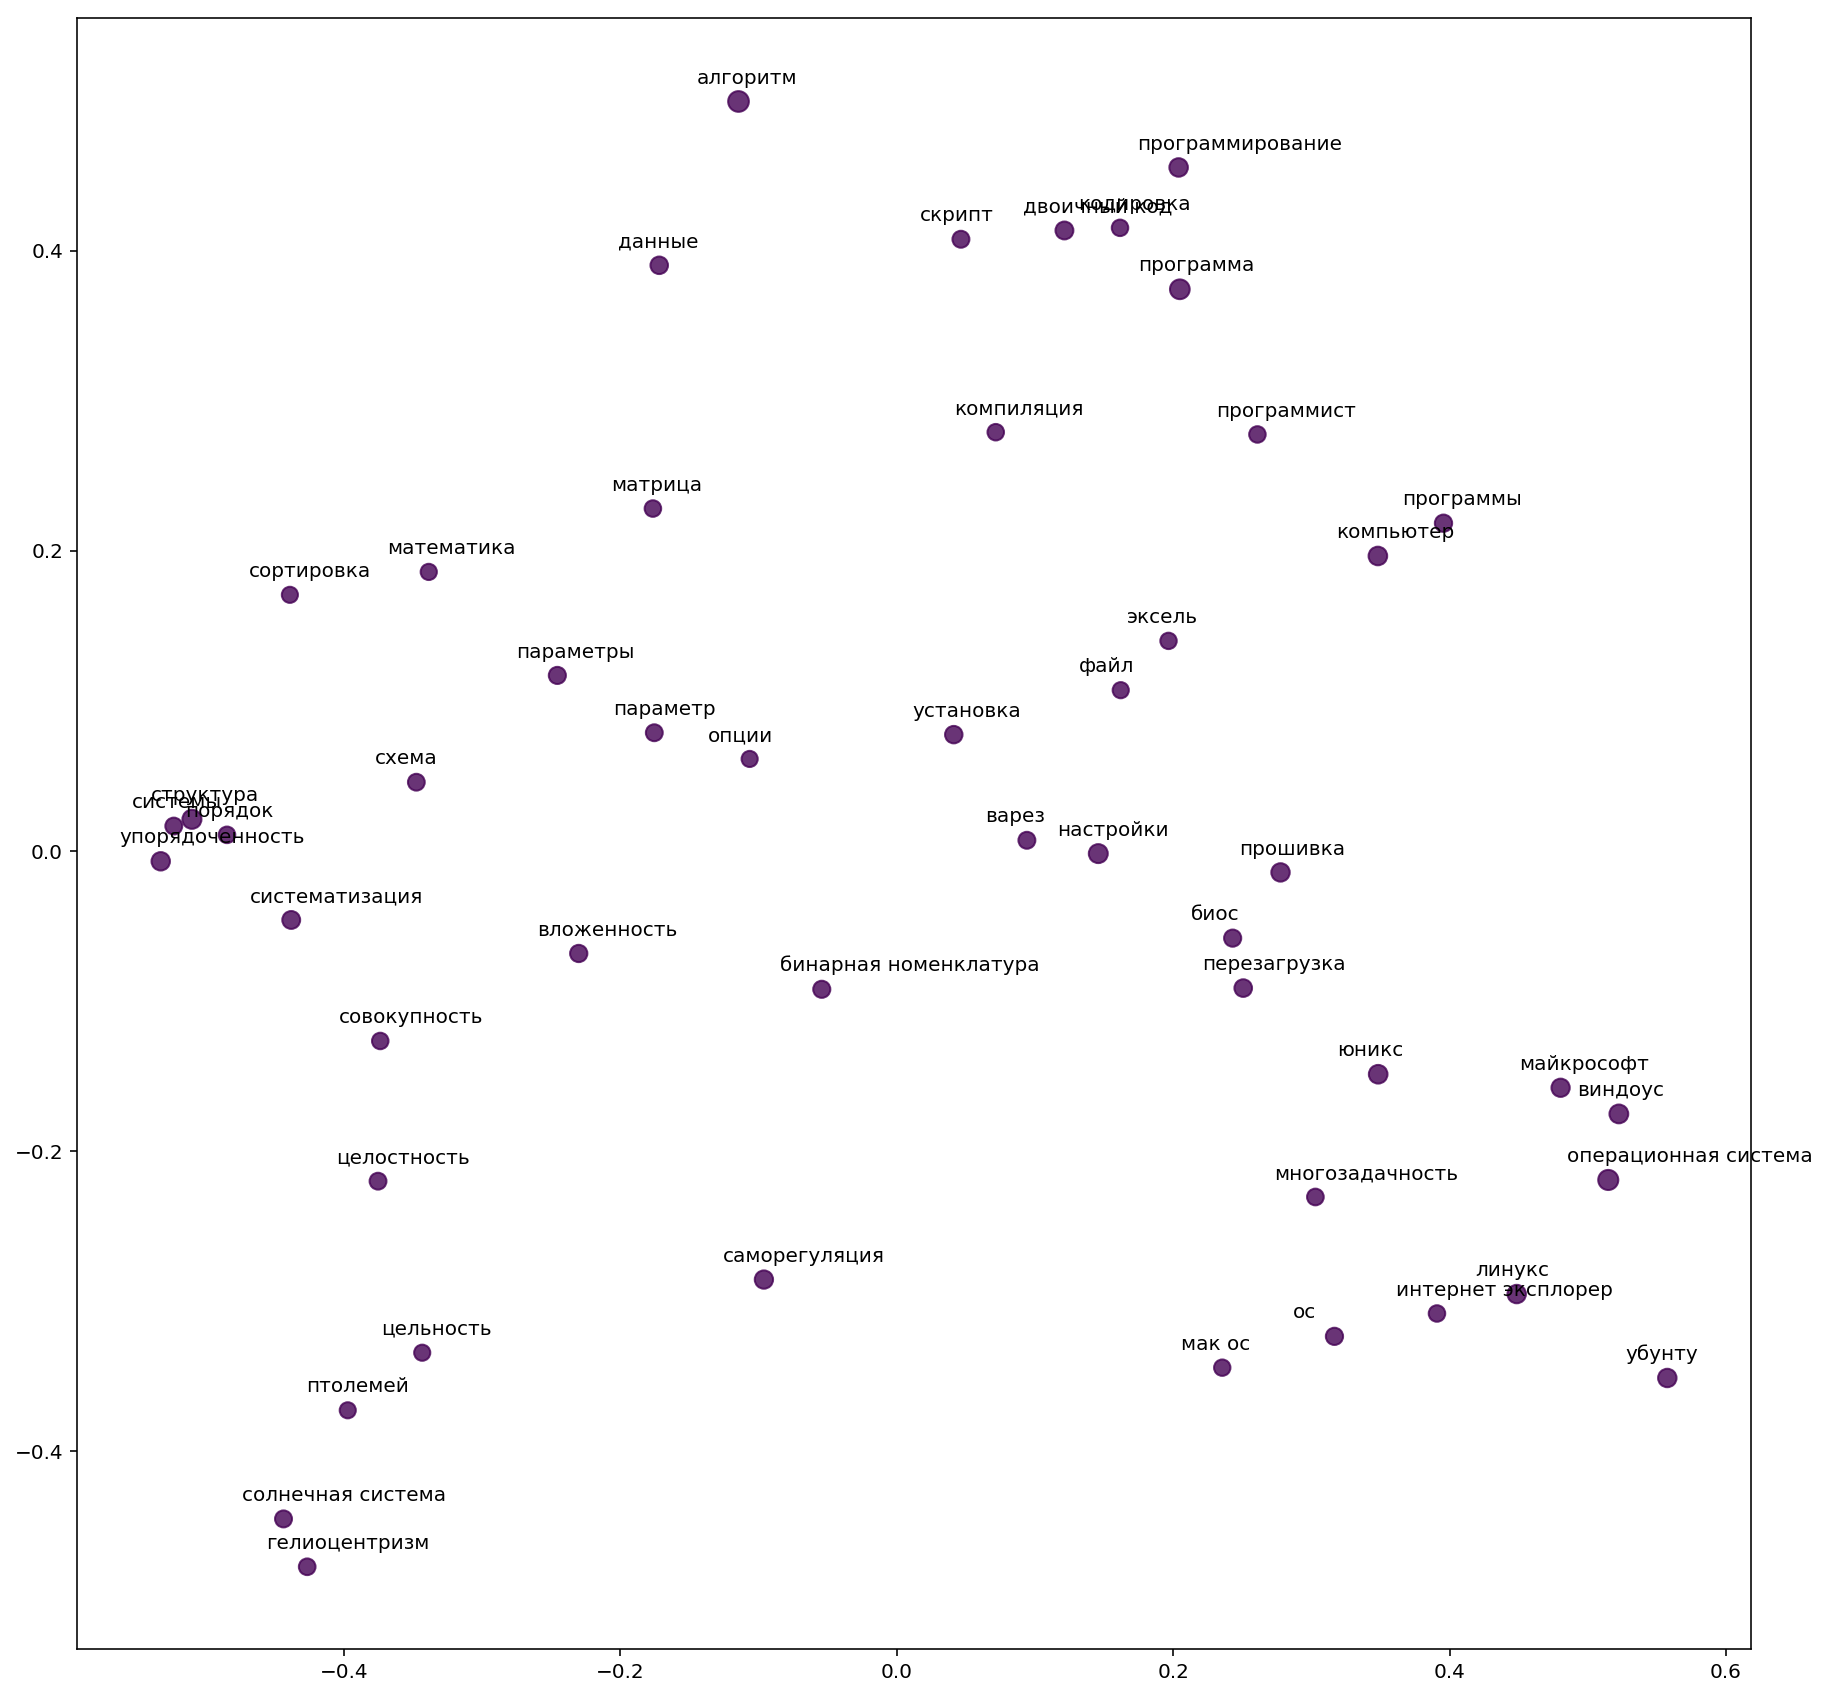

In [82]:
plot_similar('система')

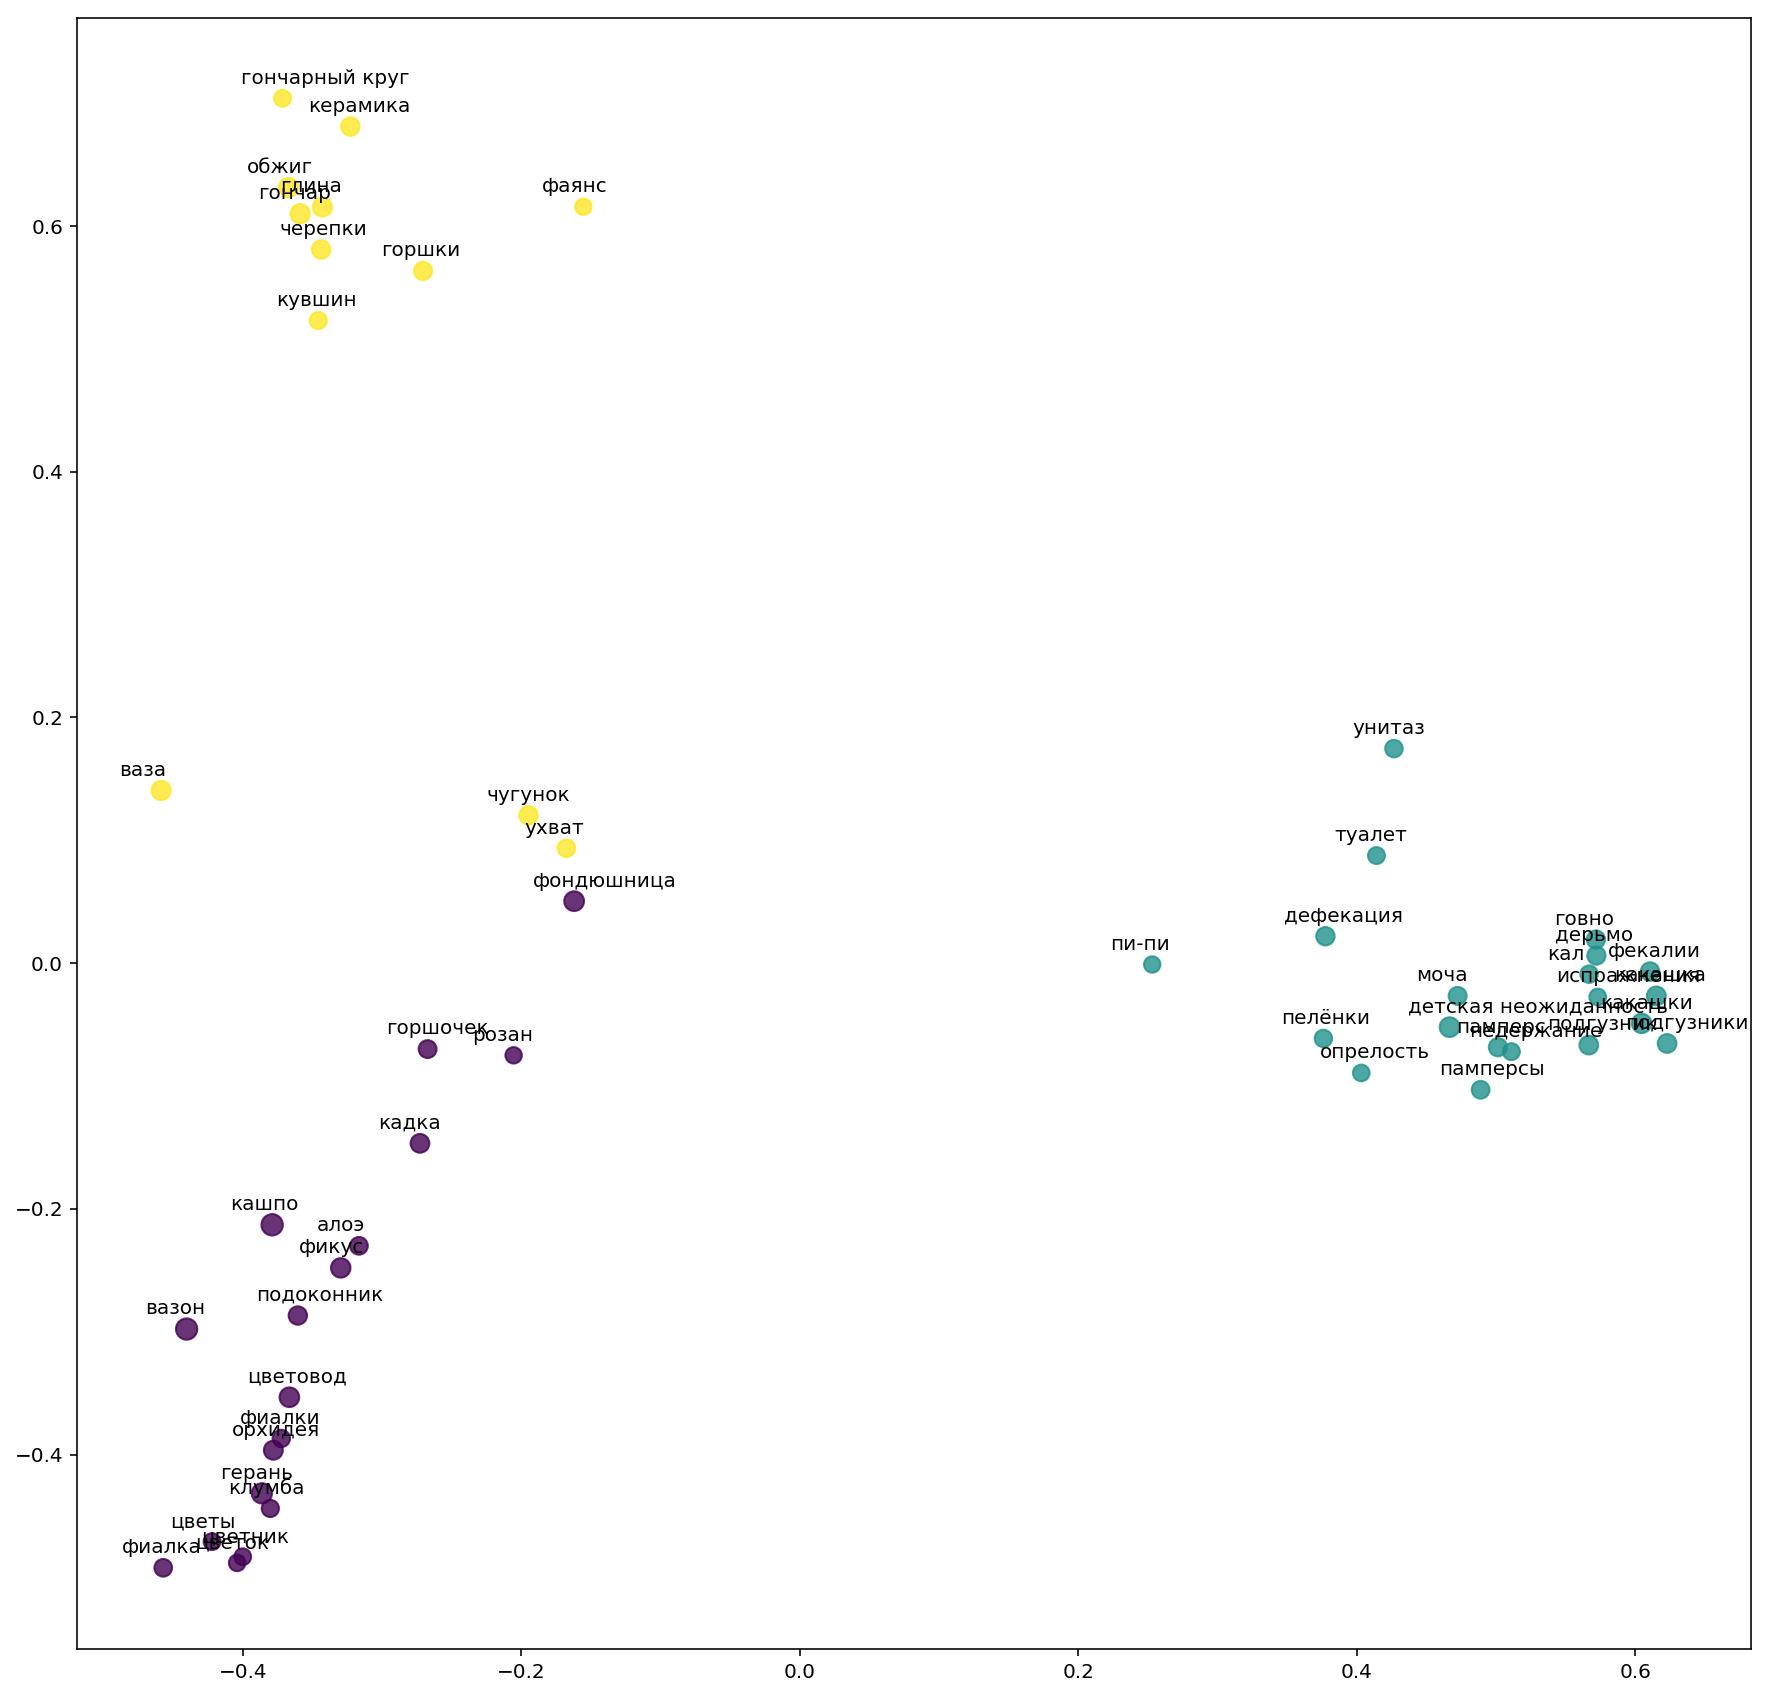

In [84]:
plot_similar('горшок')

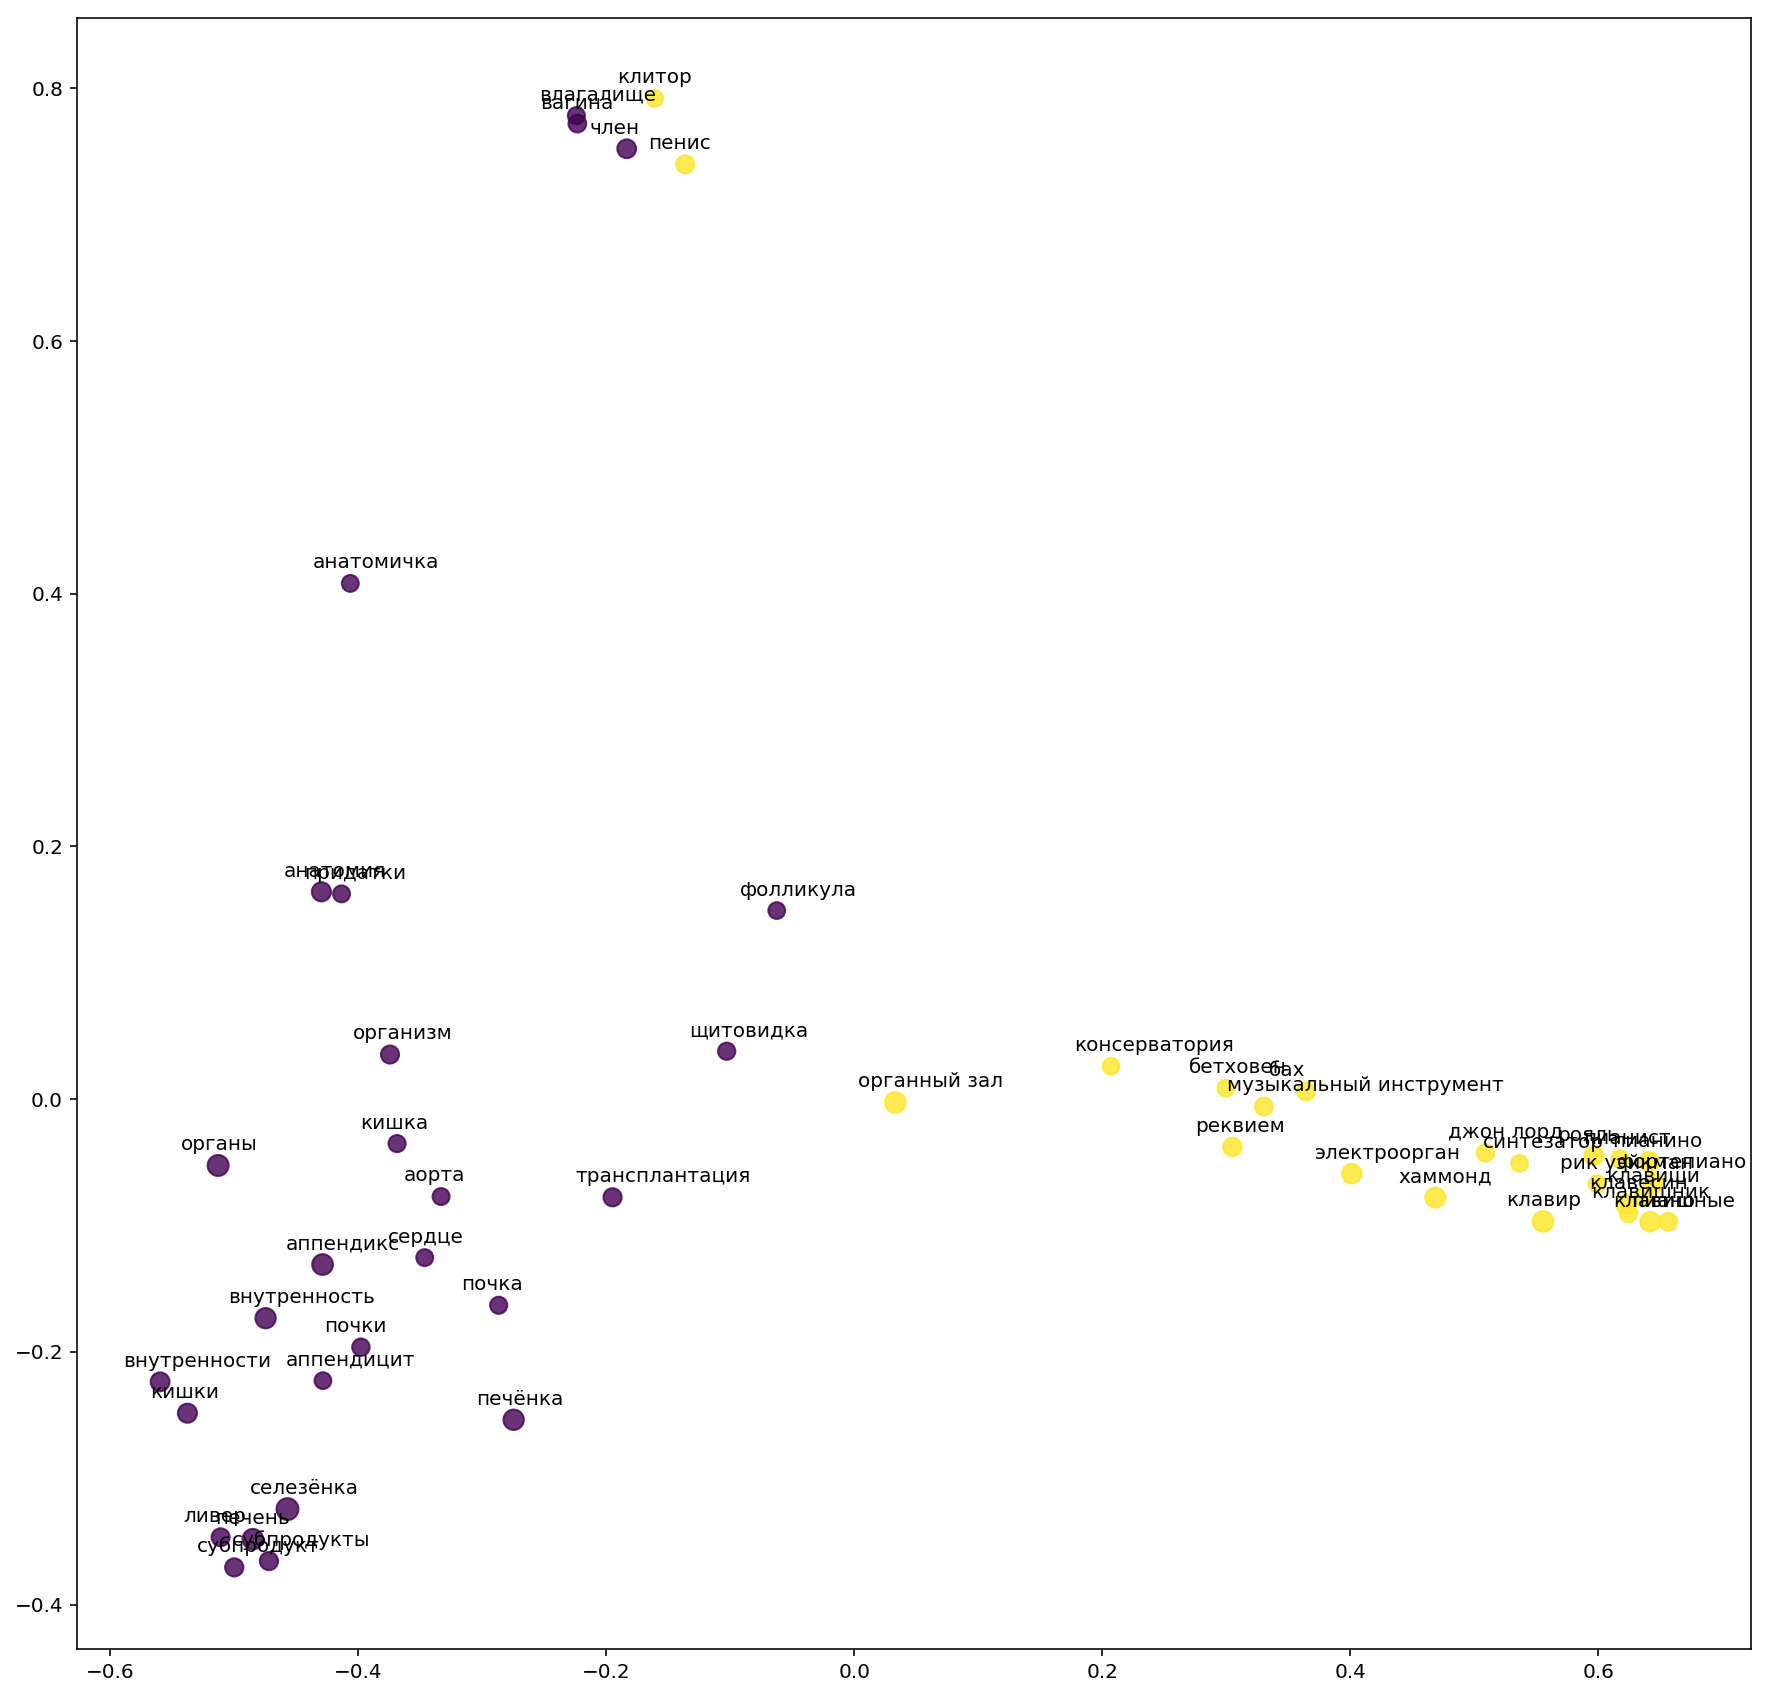

In [85]:
plot_similar('Орган')

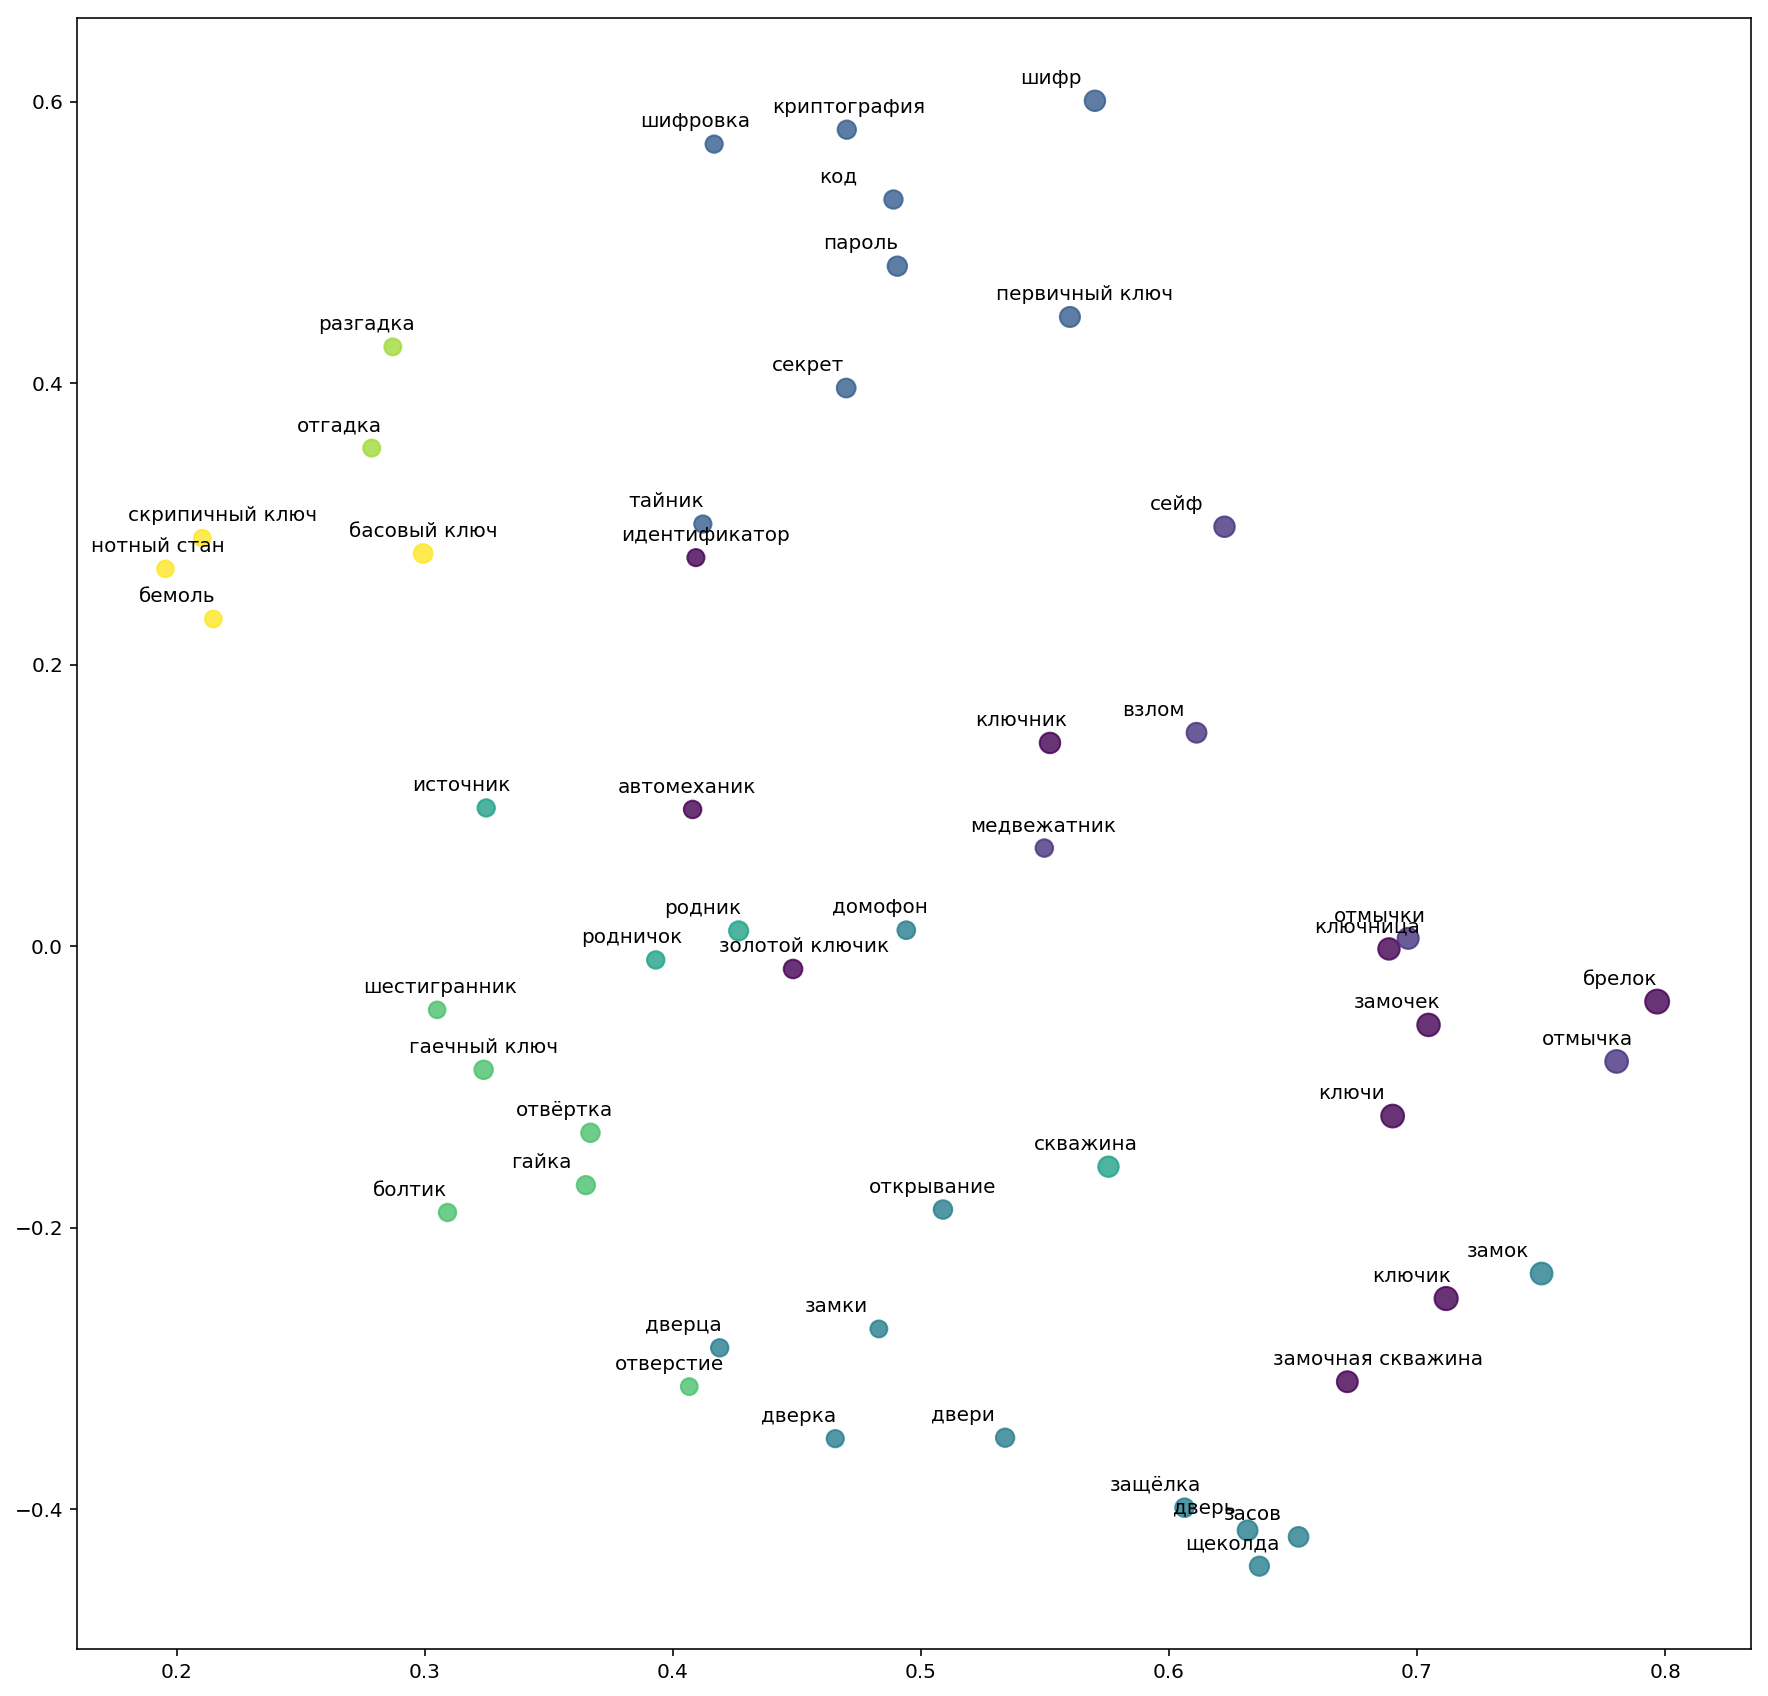

In [86]:
plot_similar('ключ', method='svd', distance3d=False)

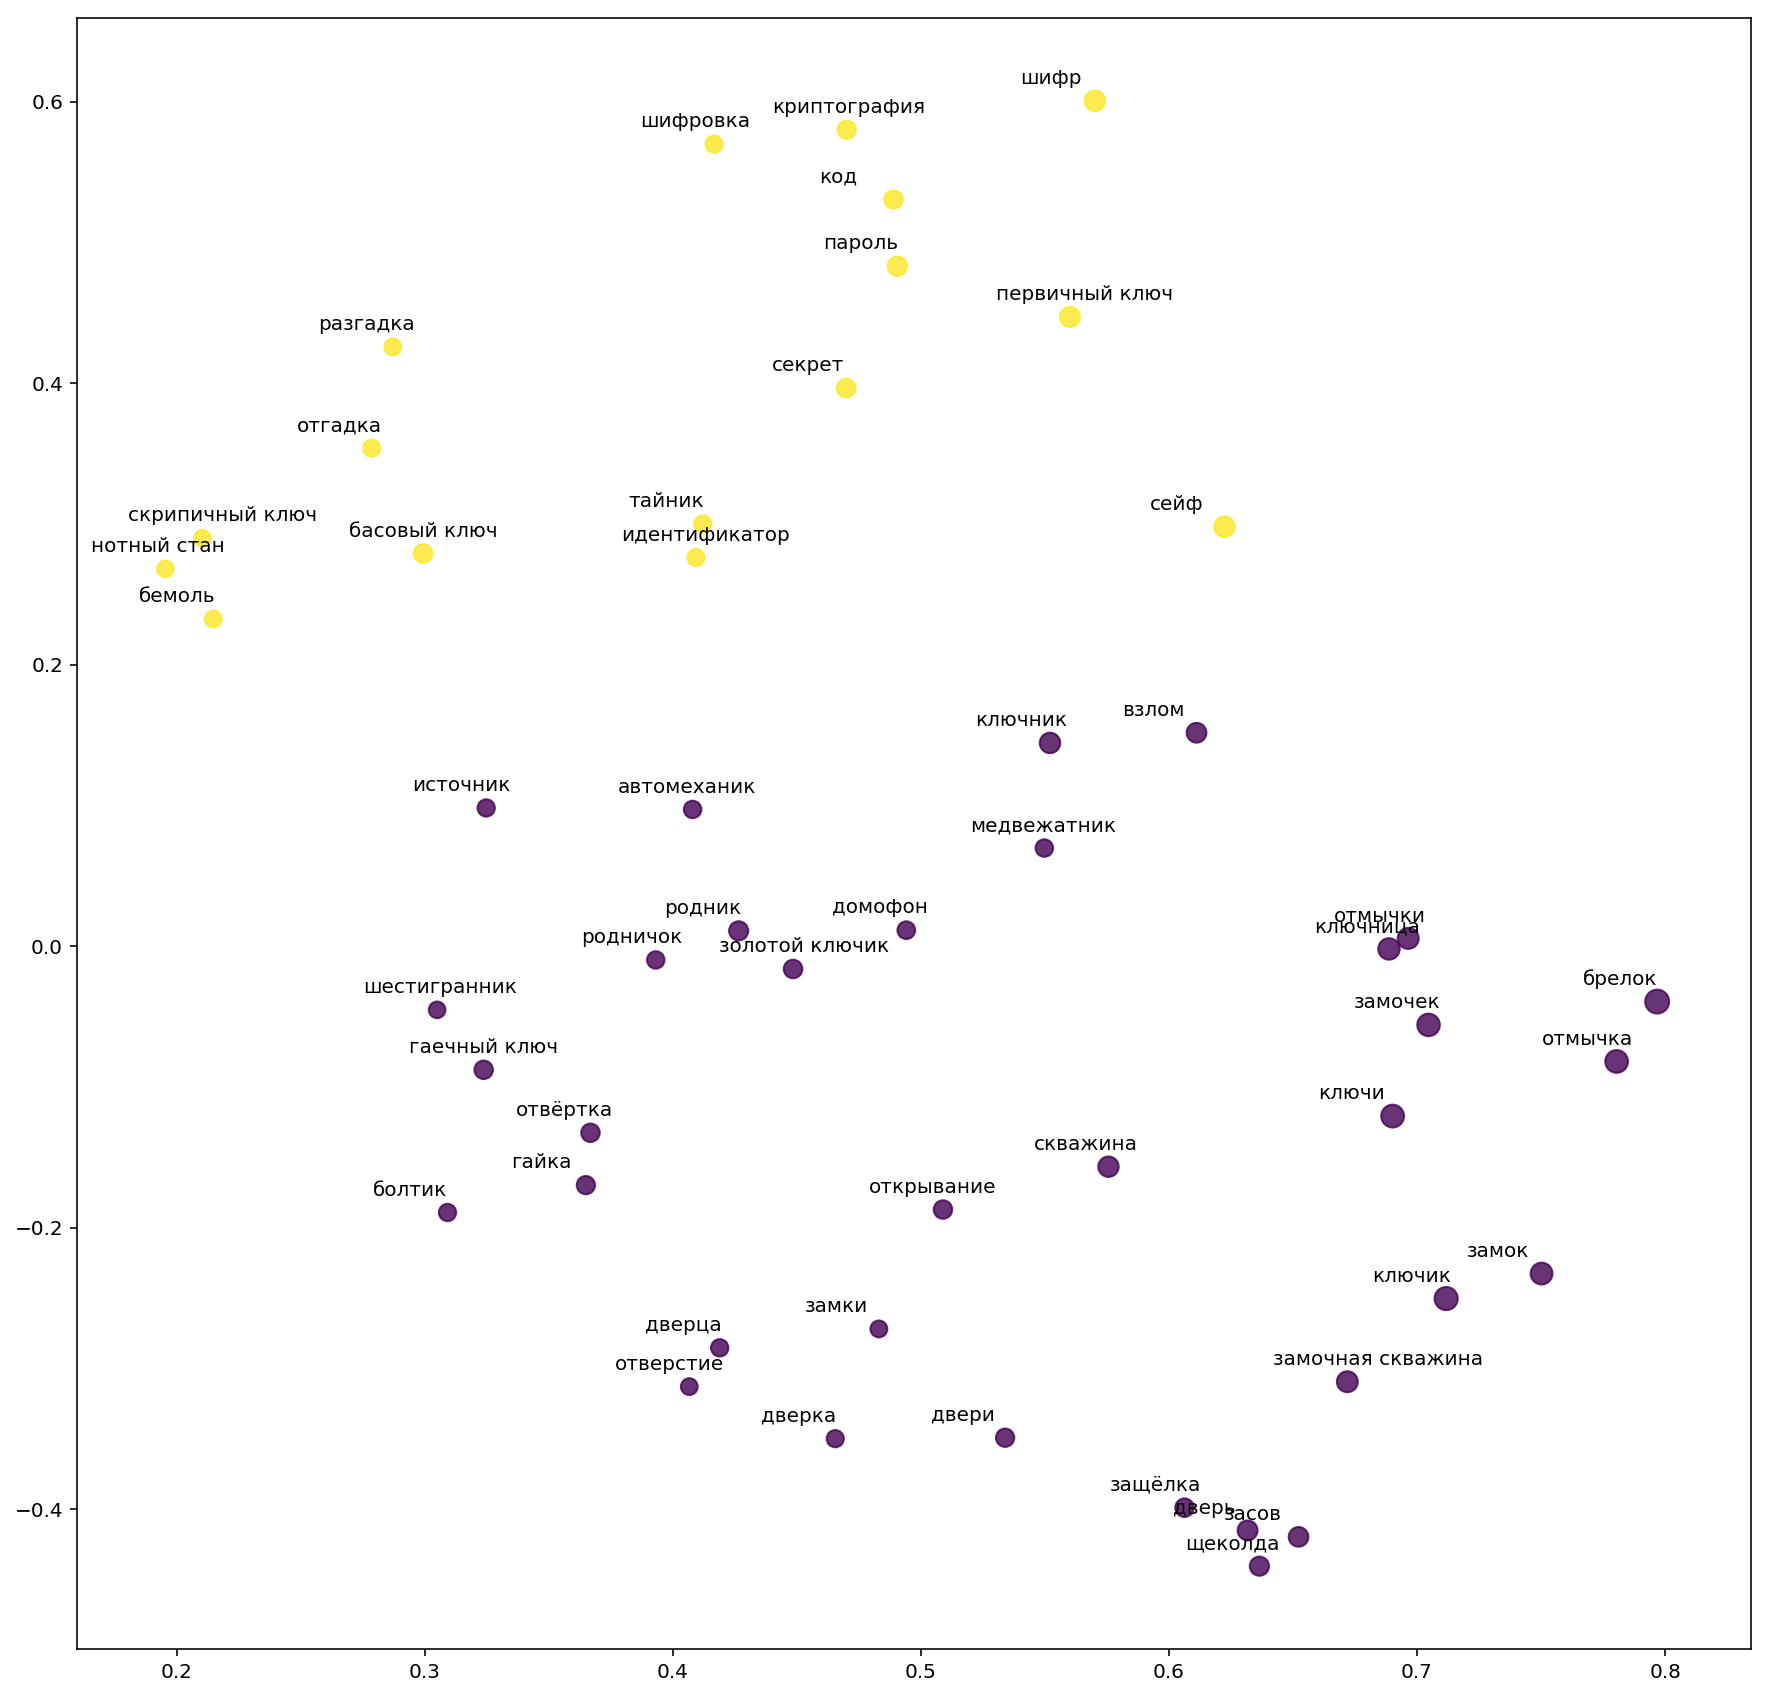

In [87]:
plot_similar('ключ', method='svd')

In [88]:
similar_clust('зубчики')

,зубец,шестерня,гребёнка,пила,шлиц,микроб,блич
0,зубец,зубчатое колесо,гребёнка,ножовка,вжик,микроб,блич
1,зубья,шестерёнка,морской гребешок,пила,шлиц,штамм,злоба дня
2,зубцы,шестерня,расчёска,спил,винтик,бацилла,блиц
3,рашпиль,эвольвента,гребешки,бензопила,,вирус,зиппер
4,зазубрины,каретка,гребешок,болгарка,,микроорганизм,ожоги
5,зуб,зубочистка,сломанность,рыба-пила,,бактерия,ломаная
6,тридцать два,колёсико,начёс,зубило,,микроорганизмы,зиппо
7,острое,,,,,микромир,
8,,,,,,зараза,
9,,,,,,чашка петри,


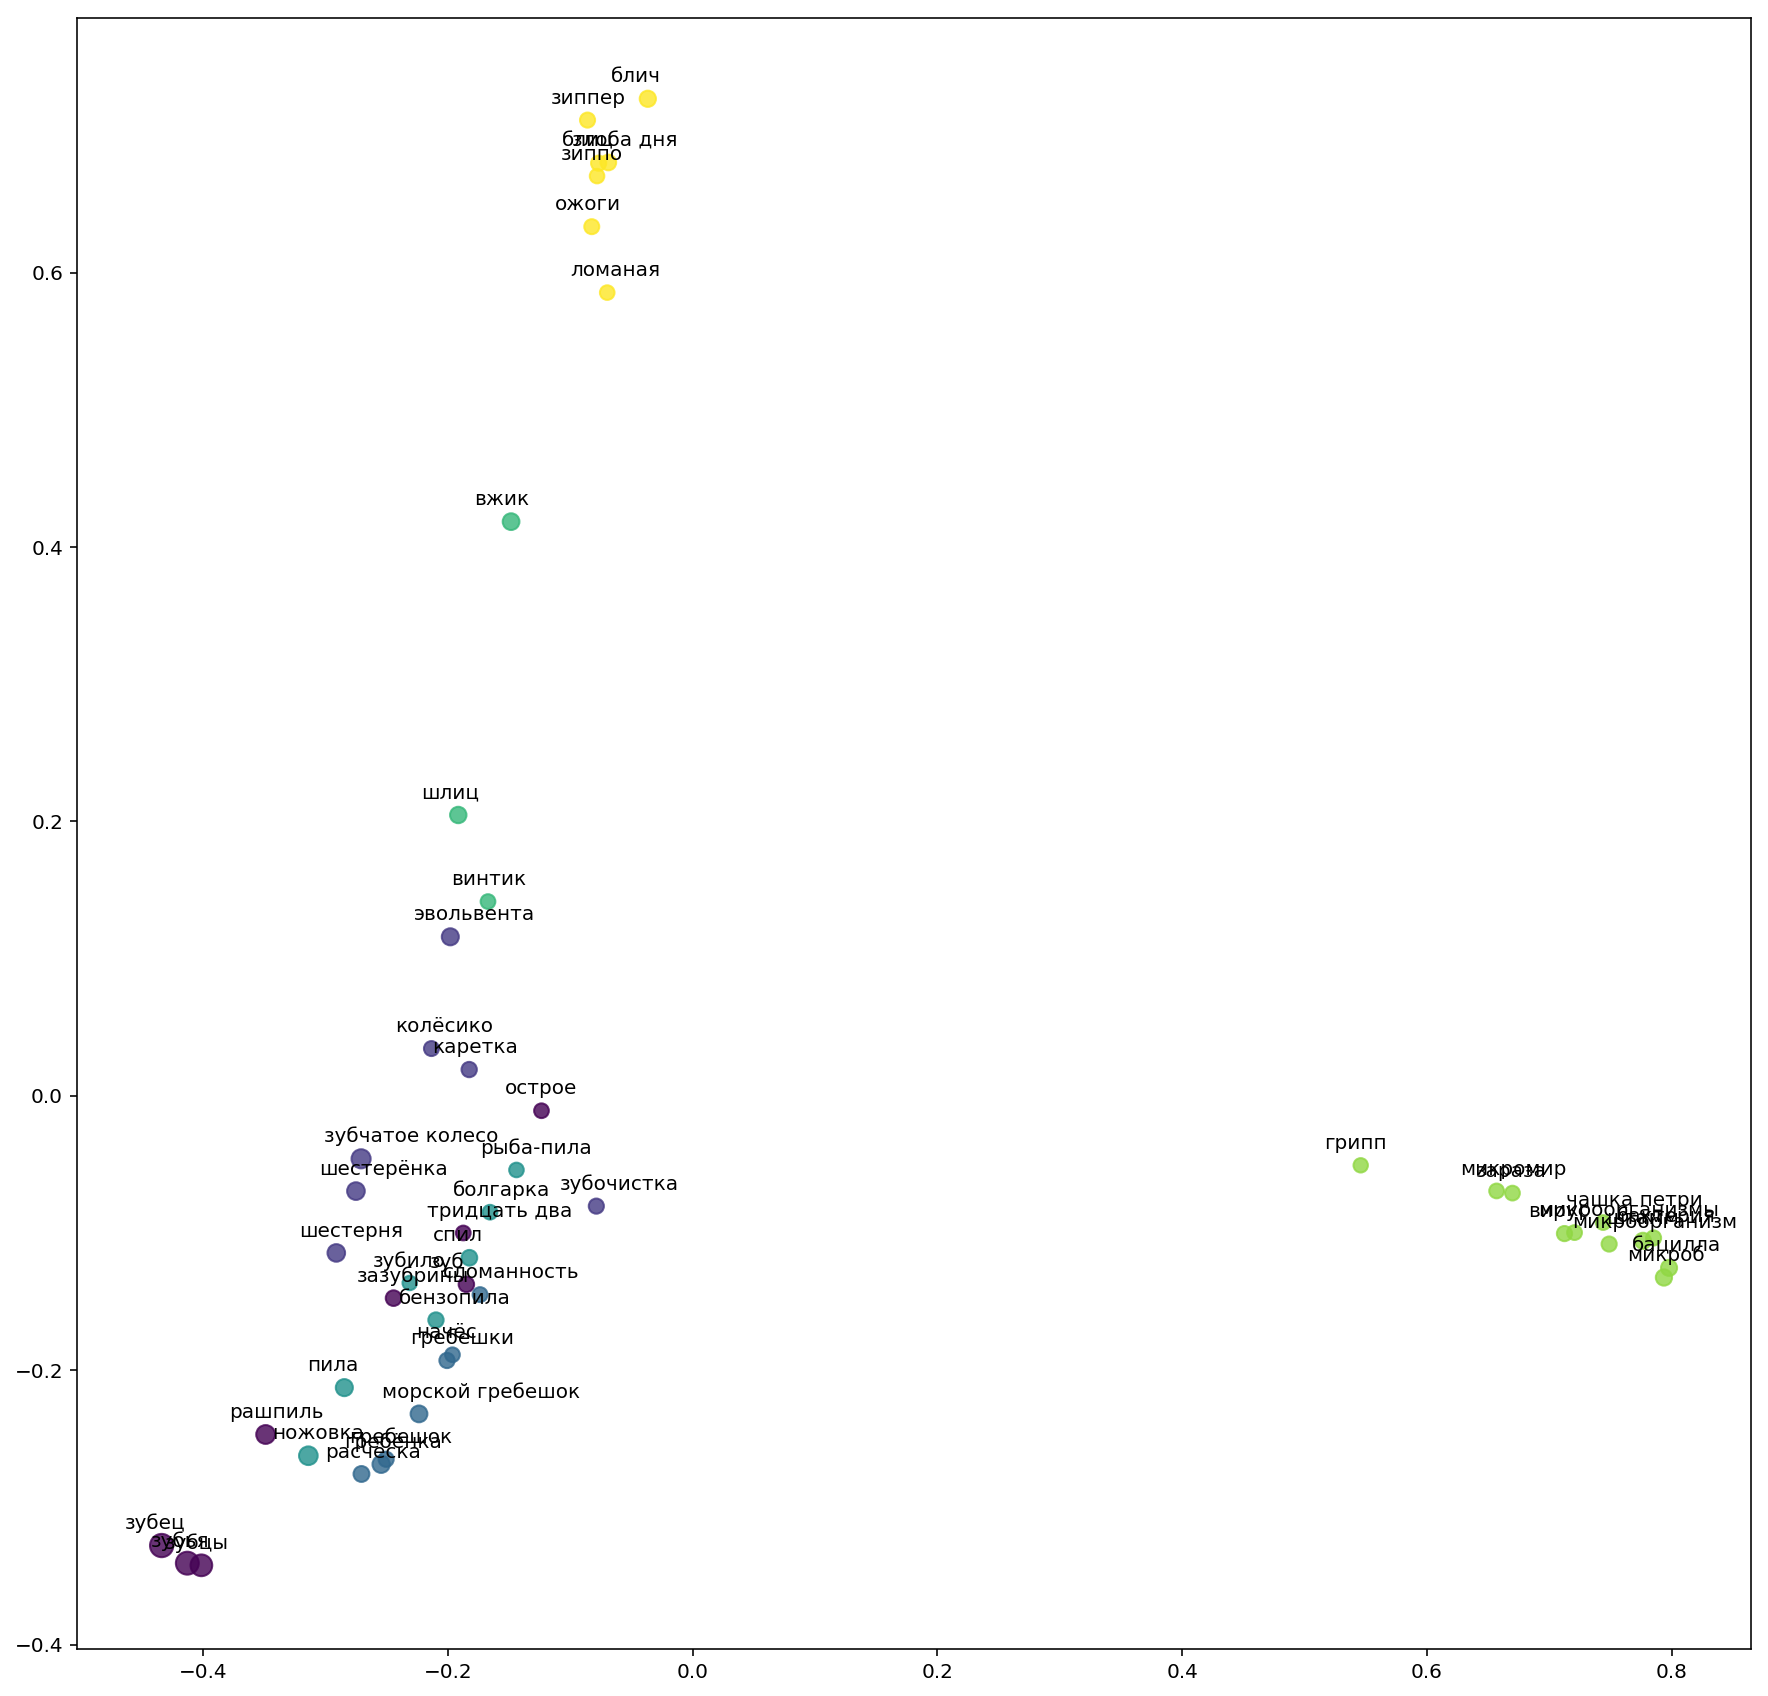

In [89]:
plot_similar('зубчики',  distance3d=False)